## Stroke Data

Source: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In this notebook I will be using 10 features to predict binary stroke outcomes (1 = stroke, 0 = no stroke). The dataset includes 11 features, but one is a unique identifier (column = 'id') that will be dropped for it adds no benefit to the analysis.

The dataset has 5110 samples, so the following models may be appropriate for the binary classification task:
- Logistic Regression 
- Support Vector Classifier
- Random Forest Classifier
- K-Nearest Neighbors Classifier

Let's get the data and see what we're working with.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [4]:
df.shape

(5110, 12)

In [5]:
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


A quick glance suggests that bmi is the only feature missing values.

In [104]:
round(df.describe())

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.0,5109.0,5109.0,5109.0,5109.0,4908.0,5109.0
mean,36514.0,43.0,0.0,0.0,106.0,29.0,0.0
std,21162.0,23.0,0.0,0.0,45.0,8.0,0.0
min,67.0,0.0,0.0,0.0,55.0,10.0,0.0
25%,17740.0,25.0,0.0,0.0,77.0,24.0,0.0
50%,36922.0,45.0,0.0,0.0,92.0,28.0,0.0
75%,54643.0,61.0,0.0,0.0,114.0,33.0,0.0
max,72940.0,82.0,1.0,1.0,272.0,98.0,1.0


The minimum age (0.0) seems a little strange. Let's make sure that nothing else seems unusual about that feature vector.

In [57]:
df[df.age == df.age.min()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0


Turns out there are 2 instances where the age is 0.08. The target = 0 in both cases. Let's explore infant patient data a little more:

In [64]:
df.sort_values(by='age').head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3618,22877,Male,0.16,0,0,No,children,Urban,114.71,17.4,Unknown,0
4021,8247,Male,0.16,0,0,No,children,Urban,109.52,13.9,Unknown,0
3968,41500,Male,0.16,0,0,No,children,Rural,69.79,13.0,Unknown,0
3392,11371,Male,0.24,0,0,No,children,Urban,89.28,14.2,Unknown,0
996,53279,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
2898,64974,Male,0.24,0,0,No,children,Urban,58.35,18.6,Unknown,0
4293,69222,Male,0.24,0,0,No,children,Urban,57.09,19.4,Unknown,0
1999,42500,Male,0.24,0,0,No,children,Rural,146.97,18.5,Unknown,0


In [18]:
len(df[df.age<1])

43

### Exploratory Data Analysis

The 10 feature vectors shown above were all missing smoking_status information. Let's explore the smoking_status feature a little more for young persons:

In [67]:
df[df.age<1]['smoking_status'].value_counts()

Unknown    43
Name: smoking_status, dtype: int64

In [68]:
df[df.age<10]['smoking_status'].value_counts()

Unknown    472
Name: smoking_status, dtype: int64

In [69]:
df[df.age<15]['smoking_status'].value_counts()

Unknown            614
never smoked        65
formerly smoked     17
smokes               3
Name: smoking_status, dtype: int64

In [75]:
len(df[(df['smoking_status'].isin(['formerly smoked','smokes'])) & (df.age<15)]) / len(df[df.age<15])

0.02861230329041488

Only 2.861% of study participants under the age of 15 are recorded as "smokes" or "formerly smoked". We will therefore classify the 614 "Unknown[s]" as "never smoked" when we prep the data.

In [76]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [77]:
len(df[(df['smoking_status'].isin(['Unknown'])) & (df.age<15)]) / len(df[df.smoking_status=='Unknown'])

0.39766839378238344

The new assignment for "Unknown[s]" under the age of 15 will take care of 40% of the total "Unknowns[s]" of the smoking_status feature

#### Balance
The distribution of classes must be considered when classification is going to be performed. We want to see a uniform distribution of classes.

<AxesSubplot:xlabel='stroke', ylabel='count'>

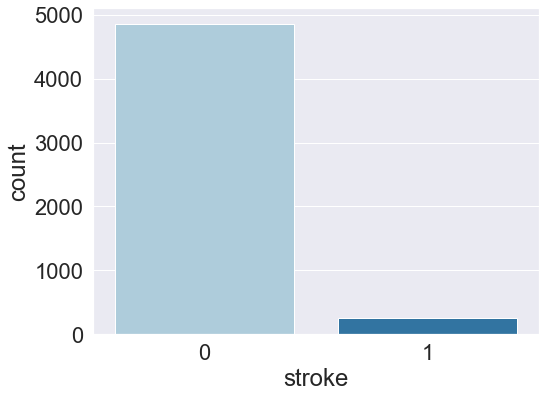

In [105]:
sns.set_theme(style="whitegrid")
sns.set(font_scale=2)

plt.figure(figsize=(8,6))
sns.countplot(data=df, x='stroke', palette='Paired')

In [39]:
len(df[df['stroke']==1])

249

In [40]:
(len(df[(df.stroke==1)]) / len(df)) * 100

4.87279843444227

## Yikes!
The minority class, stroke = 1, represents only 4.873% of outcomes (249 occurences). Without further intervention, the imbalance of the target variable will likely result in poor classification results. 

To address the imbalance, we can either undersample the majority class or oversample the minority class. Given how small the dataset is (5110 instances), we will oversample the minority class using Synthetic Minority Oversampling Technique (SMOTE). 

More on that later.

##### Gender

In [98]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [7]:
df.drop(df[df['gender'] == 'Other'].index, inplace = True)

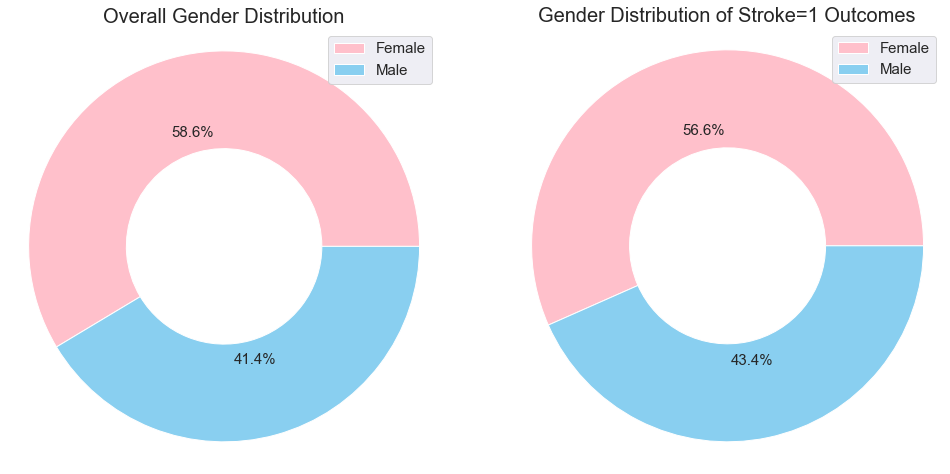

In [10]:
labels = ['Female', 'Male']
colors = ['#ffc0cb', '#89cff0']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.pie(x=df.gender.value_counts(), labels=labels, labeldistance=None, 
        autopct='%1.1f%%', colors=colors, wedgeprops=dict(width=0.5, edgecolor='w'), 
        textprops={'fontsize': 15})
ax2.pie(x=df[df.stroke==1].gender.value_counts(), labels=labels, labeldistance=None, 
        autopct='%1.1f%%', colors=colors, wedgeprops=dict(width=0.5, edgecolor='w'), 
        textprops={'fontsize': 15})


ax1.legend(prop={'size': 15})
ax2.legend(prop={'size': 15})

ax1.axis('scaled')
ax2.axis('scaled')

ax1.set_title('Overall Gender Distribution', fontdict={'fontsize':20})
ax2.set_title('Gender Distribution of Stroke=1 Outcomes', fontdict={'fontsize':20})
plt.tight_layout(pad=3)
plt.show()

Text(0.5, 1.0, 'Gender Distribution of Stroke=1 Outcomes')

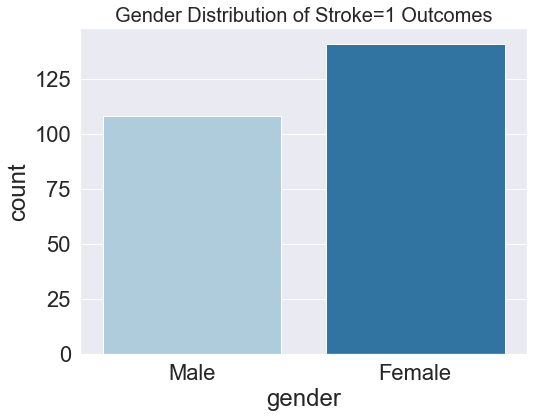

In [11]:
plt.figure(figsize=(8,6))
sns.countplot(x='gender', data=df[df.stroke == 1], palette='Paired').set_title('Gender Distribution of Stroke=1 Outcomes', fontsize=20)

#### Let's evaluate stroke prevalence as a function of age using KDEs

<AxesSubplot:xlabel='age', ylabel='Count'>

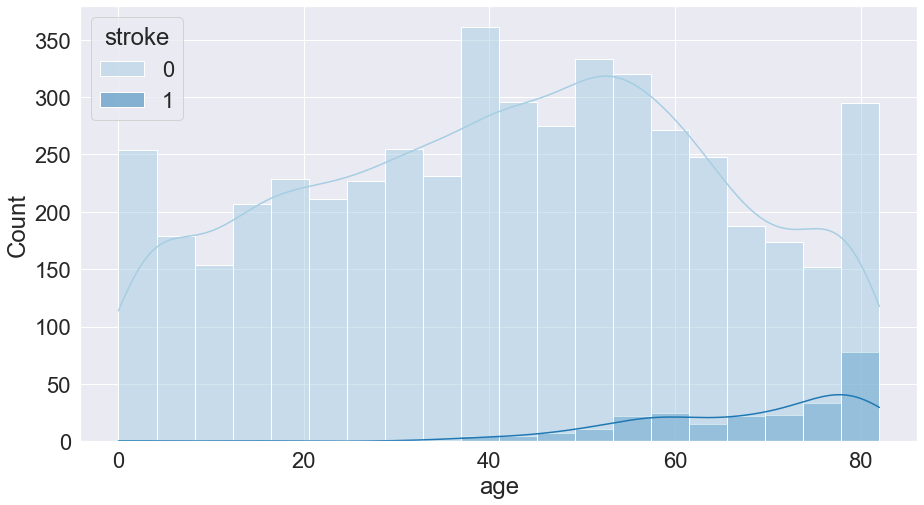

In [12]:
plt.figure(figsize=(15,8))
sns.histplot(data=df, x='age', hue='stroke', bins=20, kde=True, palette='Paired')

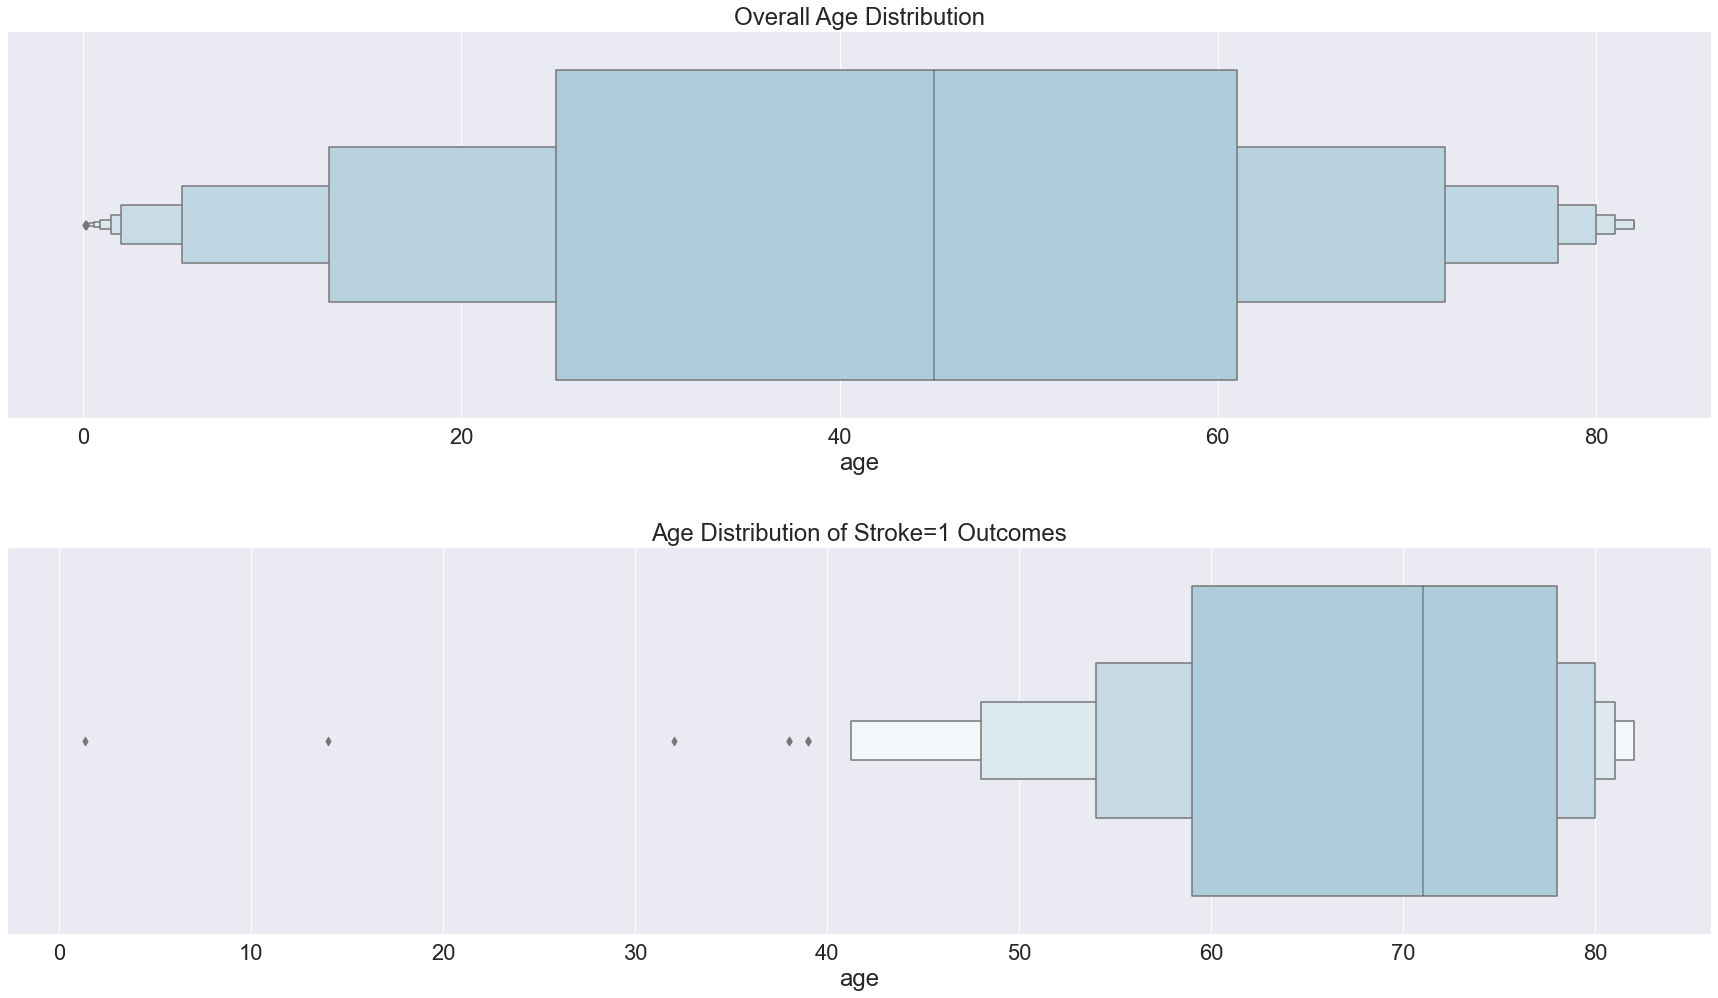

In [13]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(25,15))
sns.set(font_scale=2)

sns.boxenplot(ax=ax1, x='age', data=df, palette='Paired')
sns.boxenplot(ax=ax2, x=df[df.stroke==1].age, data=df, palette='Paired')

ax1.set_title('Overall Age Distribution',)
ax2.set_title('Age Distribution of Stroke=1 Outcomes',)


fig.tight_layout(pad=2.0)

Text(0.5, 1.0, 'Work Type')

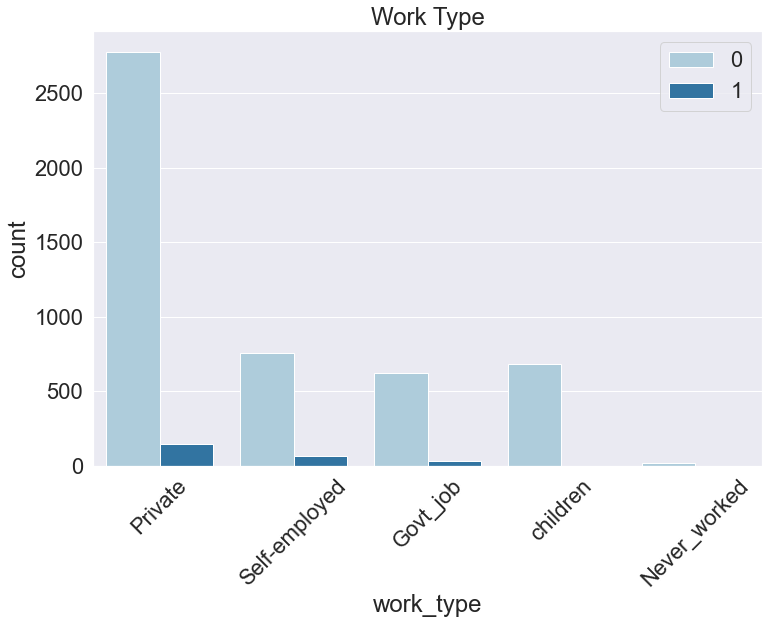

In [14]:
plt.figure(figsize=(12,8))
sns.countplot(x='work_type', data=df, hue='stroke', palette='Paired')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.title('Work Type')

In [15]:
len(df[(df.work_type=='children') & (df.stroke==1)])

2

In [22]:
len(df[(df.work_type=='Never_worked') & (df.stroke==1)])

0

I'm guessing that the majority of individuals under this classification are young. If so, we should be cognizant of potential multicollinearity between 'age' and 'work_type'.

In [29]:
df[df.work_type == 'Never_worked'].describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,22.000000,22.000000,22.0,22.0,22.000000,22.000000,22.0
mean,38274.409091,16.181818,0.0,0.0,96.042727,25.545455,0.0
std,20166.419938,2.342899,0.0,0.0,28.697132,7.441757,0.0
min,11702.000000,13.000000,0.0,0.0,59.990000,14.600000,0.0
25%,19830.750000,14.250000,0.0,0.0,78.457500,20.975000,0.0
50%,36054.500000,16.000000,0.0,0.0,86.020000,23.150000,0.0
75%,57202.000000,17.000000,0.0,0.0,112.807500,28.350000,0.0
max,71966.000000,23.000000,0.0,0.0,161.280000,44.900000,0.0


Indeed, the youngest is 13 and the oldest is 23. We'll keep this in mind as we move forward.

[Text(0, 0, 'formerly smoked'),
 Text(1, 0, 'never smoked'),
 Text(2, 0, 'smokes'),
 Text(3, 0, 'Unknown')]

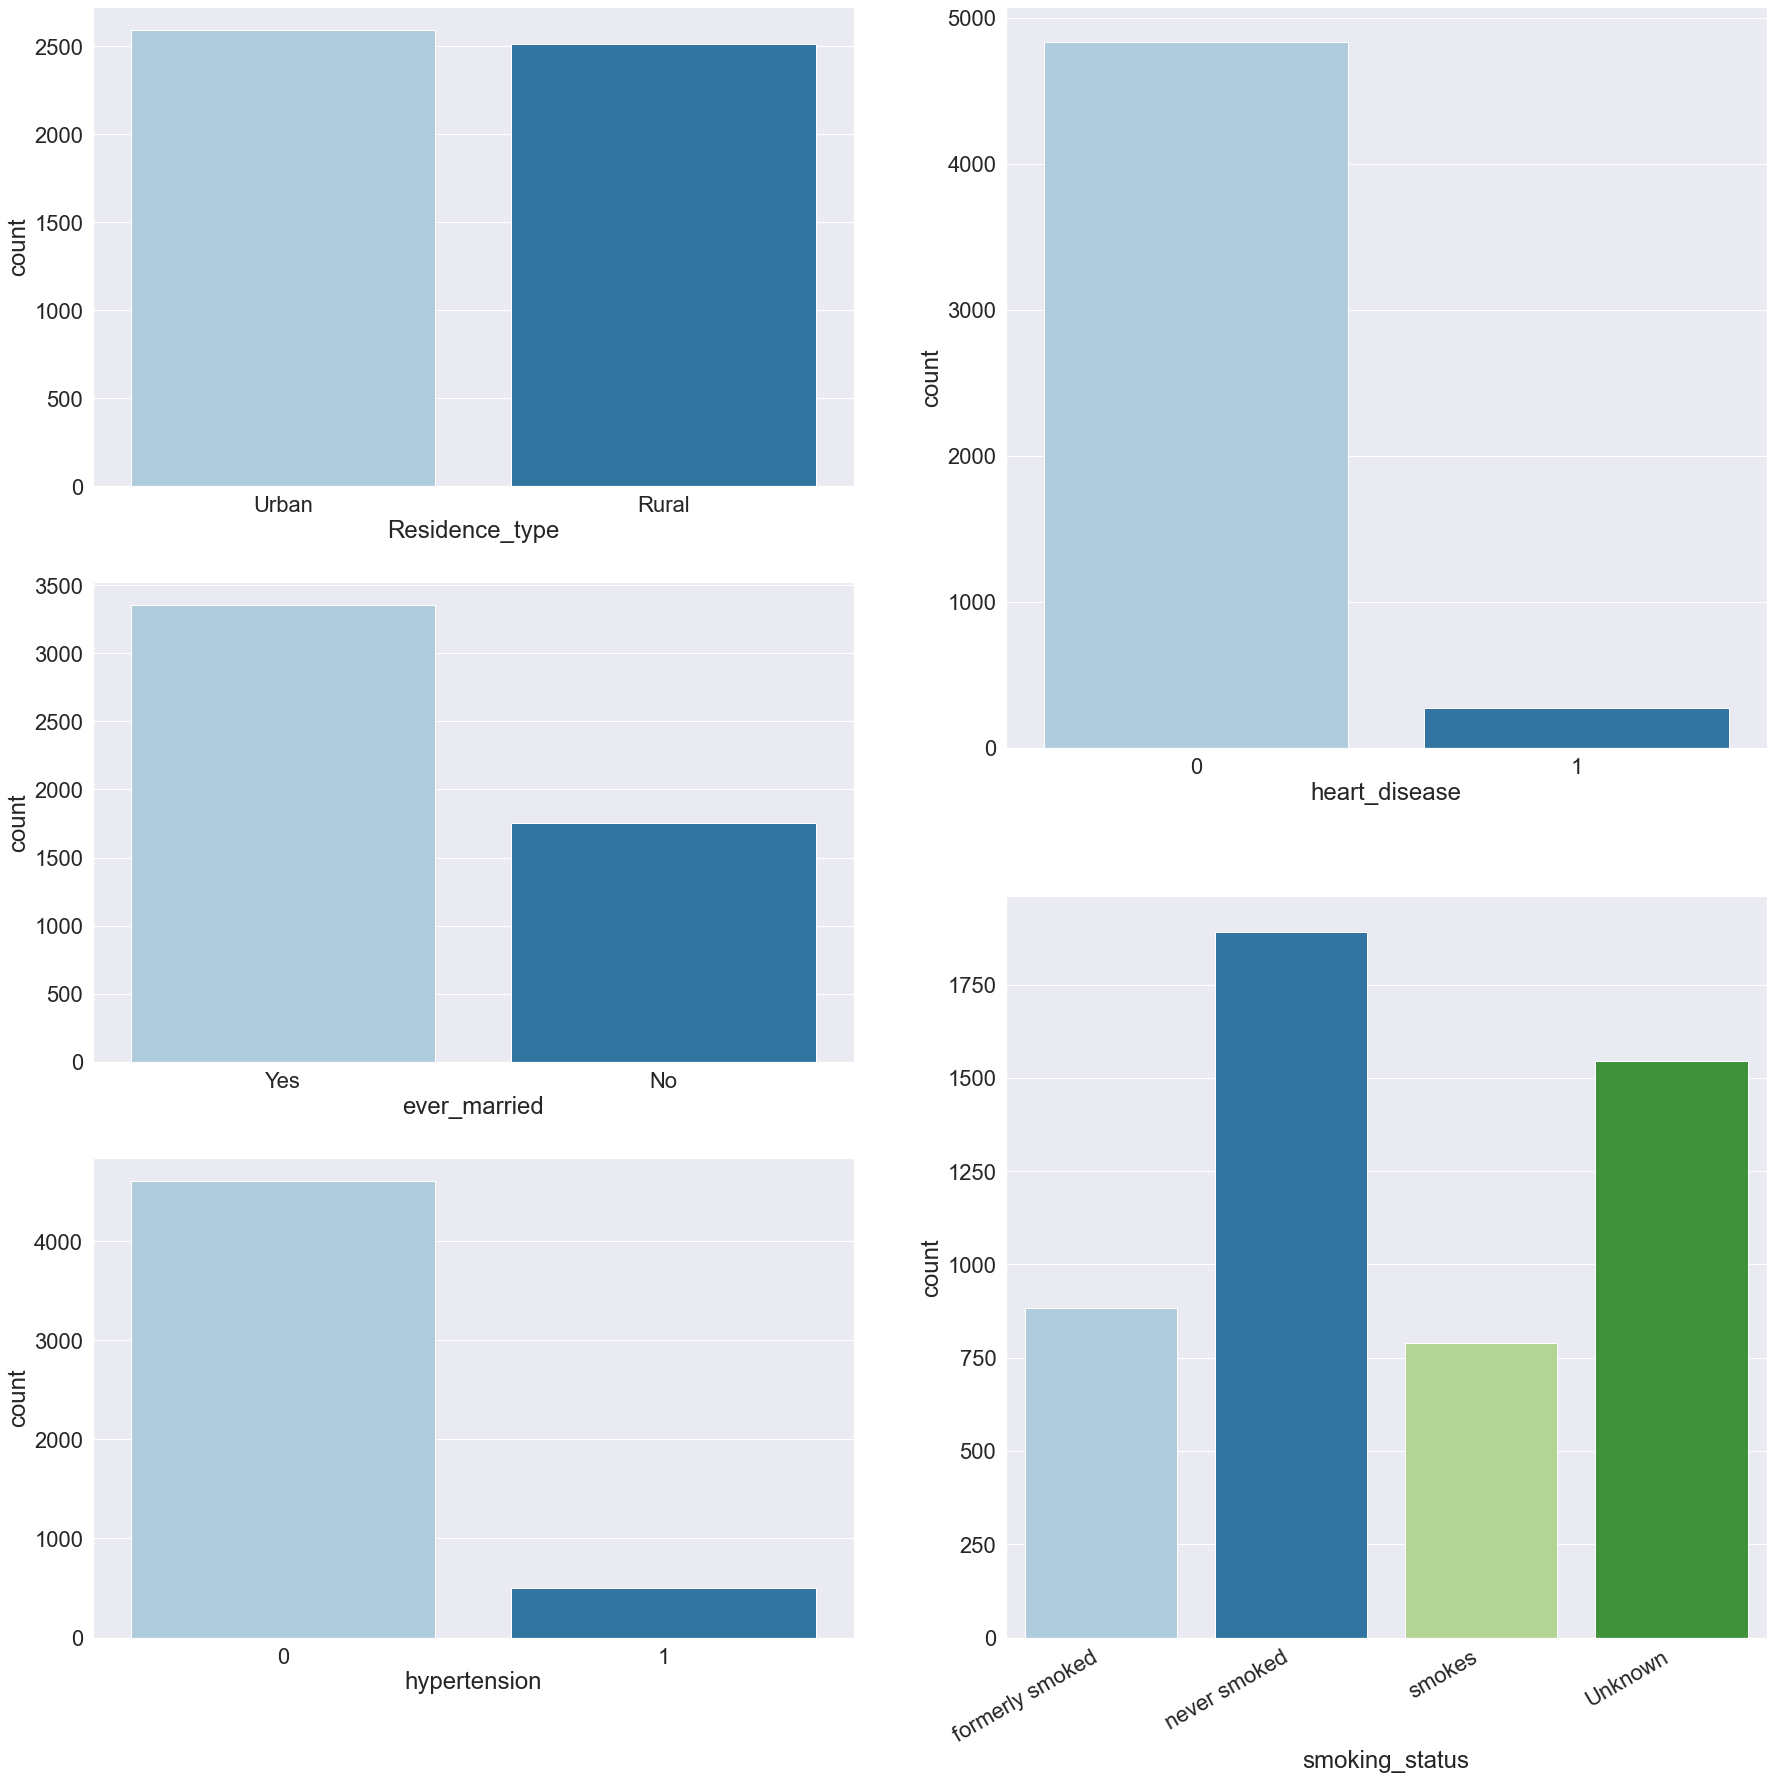

In [30]:
sns.set(font_scale=2)
plt.figure(figsize=(30,30))
ax1 = plt.subplot(321)
ax2 = plt.subplot(323)
ax3 = plt.subplot(325)
ax4 = plt.subplot(222)
ax5 = plt.subplot(224)

sns.countplot(data=df, ax=ax1, x='Residence_type', palette='Paired',)
sns.countplot(data=df, ax=ax2, x='ever_married',palette='Paired')
sns.countplot(data=df, ax=ax3, x='hypertension', palette='Paired')
sns.countplot(data=df, ax=ax4, x='heart_disease',  palette='Paired')
sns.countplot(data=df, ax=ax5, x='smoking_status', palette='Paired')

ax5.set_xticklabels(ax5.get_xticklabels(),rotation = 30, horizontalalignment='right')

The above graphs further support the need for a resampling technique. 

Also, recall that ~40% of the 'Unknown' smoking_status instances are going to be recategorized as 'never smoked'

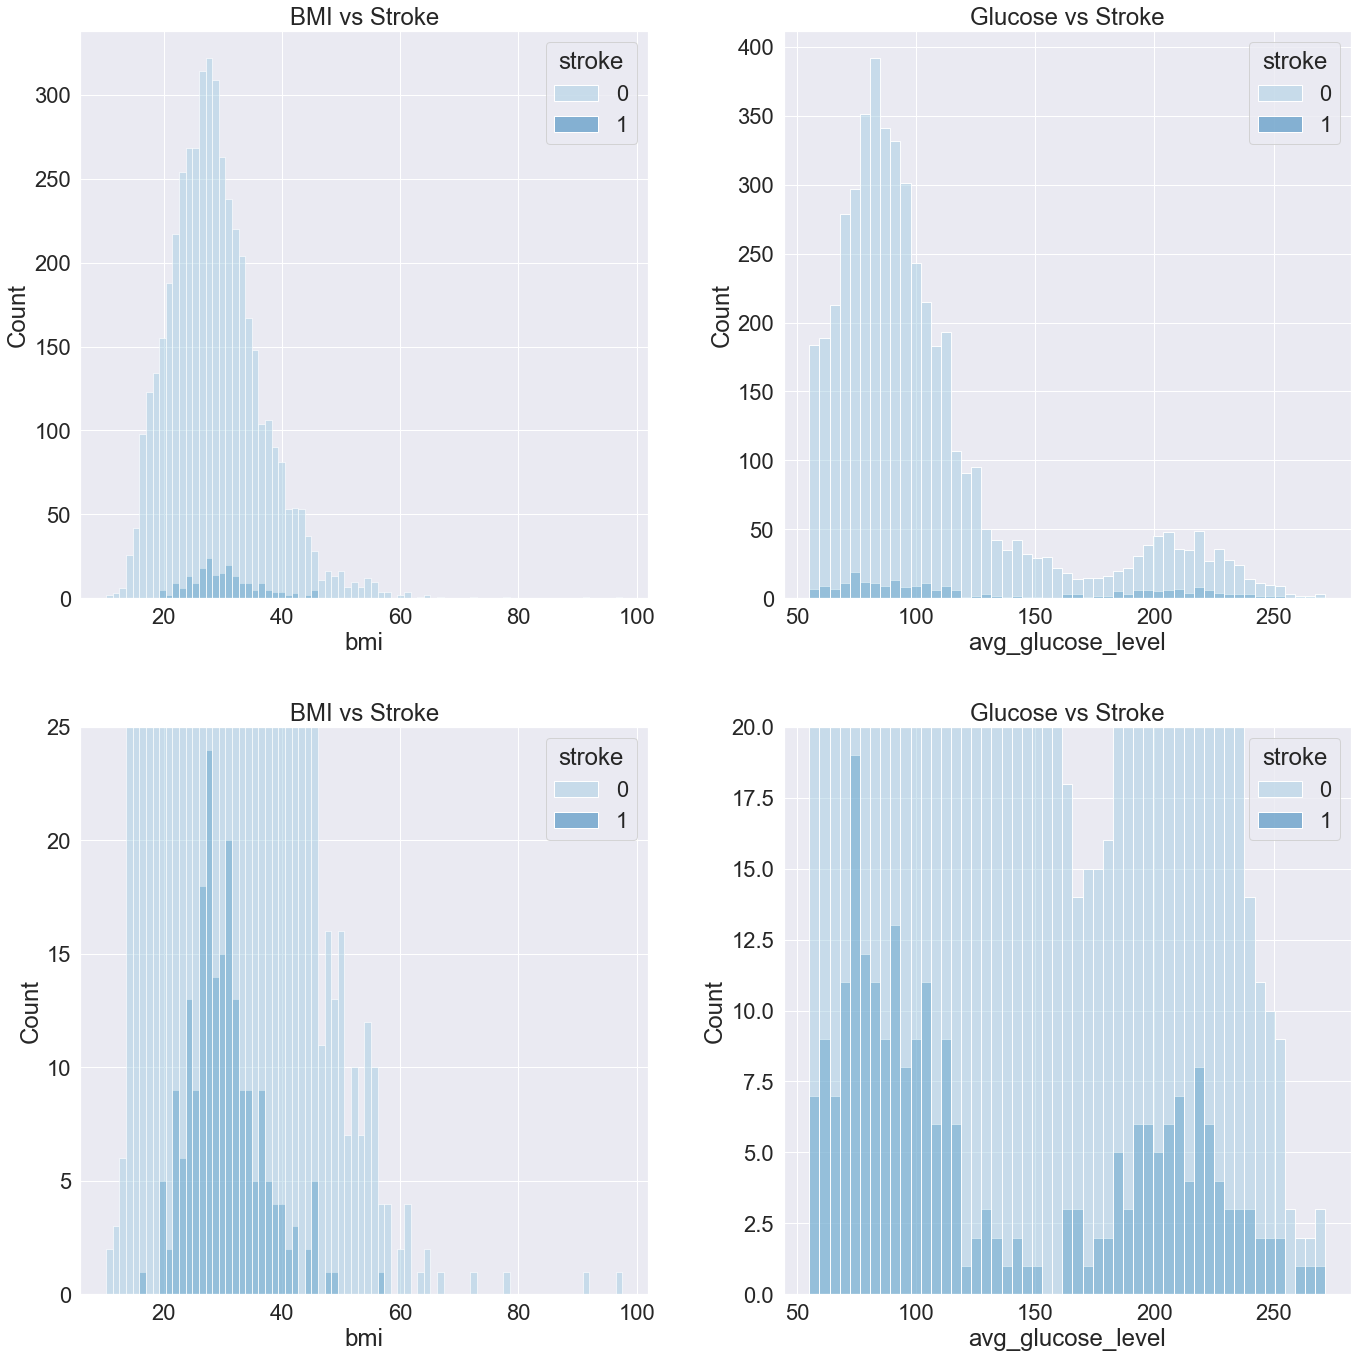

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,20))

sns.histplot(data=df, ax=ax1, x='bmi', hue='stroke', palette='Paired').set_title('BMI vs Stroke')
sns.histplot(data=df, ax=ax2, x='avg_glucose_level',  hue='stroke', palette='Paired').set_title('Glucose vs Stroke')
sns.histplot(data=df, ax=ax3, x='bmi', hue='stroke', palette='Paired').set_title('BMI vs Stroke')
sns.histplot(data=df, ax=ax4, x='avg_glucose_level',  hue='stroke', palette='Paired').set_title('Glucose vs Stroke')
ax3.set_ylim([0,25])
ax4.set_ylim([0,20])
plt.tight_layout(pad=2)

Visually, there is no clear correlation between either bmi and stroke outcomes or avg_glucose_level and stroke outcomes in our dataset. 

In [35]:
df.bmi.isna().sum()/len(df) * 100

3.9342337052260716

Only 3.93% of bmi values are NaN, so I'll impute the median for missing values of this feature.

<AxesSubplot:xlabel='avg_glucose_level'>

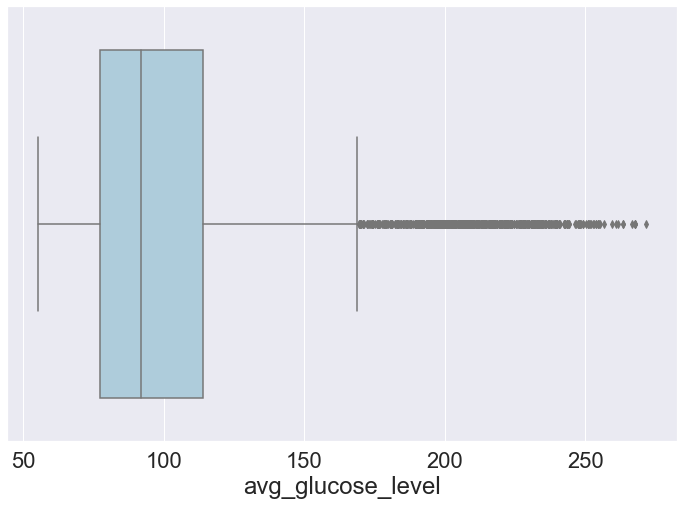

In [36]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df, x='avg_glucose_level', palette='Paired')

avg_glucose_level appears to have a lot of outliers. Let's figure out just how many outliers it has.


In [347]:
len(df[df['avg_glucose_level'] > df['avg_glucose_level'].quantile(0.99)])

52

In [38]:
outliers = df[(np.abs(df.avg_glucose_level - df.avg_glucose_level.mean()) > (3*df.avg_glucose_level.std()))]

In [349]:
len(outliers)

49

There are 52 individuals above the 99th percentile and 49 individuals that are more than 3 standard deviations above the mean.

We know that stroke=1 is true for only ~5% of the dataset so before we consider removing the anomalous individuals, let's take note of the effect of an exceptionally high avg_glucose_level on the target variable. 

Text(0.5, 1.0, 'Stroke Outcomes w/ Respect to Anomolous Glucose Levels')

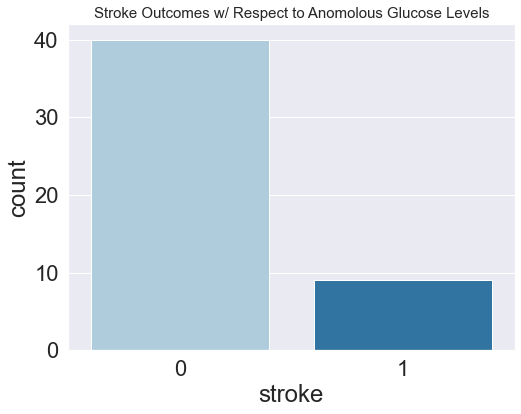

In [39]:
plt.figure(figsize=(8,6))
sns.countplot(data=outliers, x='stroke', palette='Paired')

plt.title('Stroke Outcomes w/ Respect to Anomolous Glucose Levels', fontsize='15')

In [52]:
len(outliers[outliers.stroke==1])/len(outliers)*100
# 18% of our outliers are of the target class

18.367346938775512

In [54]:
# Percentage of stroke = 1 instances where avg_glucose is an outlier
(len(outliers[outliers.stroke==1])/len(df[df.stroke==1])) * 100

3.614457831325301

### Looks like these aren't outliers, rather we have a wide distribution

We can see that 18.367% of the individuals with an avg_glucose_level more than 3 standard deviations above the mean have had a stroke, accounting for 3.614% of our total stroke=1 instances.

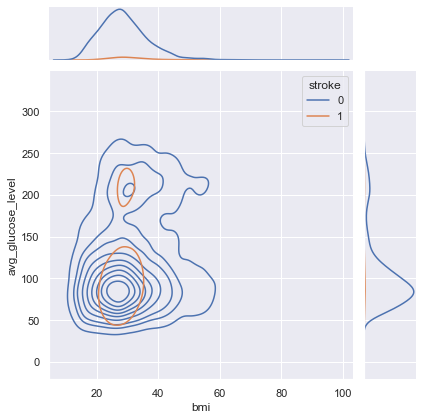

In [55]:
sns.set(font_scale=1)
sns.jointplot(data=df, x='bmi', y='avg_glucose_level', hue='stroke', kind='kde')

# Feature Engineering

In [56]:
df[df.age<15].head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,16523,Female,8.00,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.00,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0


Change smoking_status for individuals under 15 from "Unknown" to "never smoked"

In [12]:
def smokeAdjuster(age, smoke):
    if (age<15):
        if (smoke=="Unknown"):
            return "never smoked"
        else: 
            return smoke
    else:
        return smoke

In [13]:
df['smoking_status'] = df.apply(lambda row: smokeAdjuster(row['age'],row['smoking_status']), axis=1)

Let's make sure that it works, and that only "Unknown"s under the age of 15 have been changed

In [14]:
df[df.age<15].smoking_status.value_counts()

never smoked       679
formerly smoked     17
smokes               3
Name: smoking_status, dtype: int64

In [15]:
df[df.age>15].smoking_status.value_counts()

never smoked       1805
Unknown             909
formerly smoked     865
smokes              786
Name: smoking_status, dtype: int64

### Pipelines

The remaining manipulations will be implemented via Pipelines/Column Transformers 

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [17]:
X = df.drop(['id','stroke'], axis=1)
y = df['stroke']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
print('Shape of X_train: {}\n'.format(X_train.shape))
print('Shape of X_test: {}\n'.format(X_test.shape))

Shape of X_train: (3423, 10)

Shape of X_test: (1686, 10)



In [20]:
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4540,Male,4.0,0,0,No,children,Urban,87.00,19.0,never smoked
3379,Female,41.0,0,0,Yes,Private,Urban,74.85,24.8,formerly smoked
479,Male,54.0,1,0,Yes,Private,Rural,198.69,NaN,smokes
3683,Male,80.0,0,1,Yes,Self-employed,Rural,95.49,31.6,Unknown
2997,Male,71.0,0,1,Yes,Private,Urban,204.98,NaN,formerly smoked


In [21]:
num_scaling_feats = ['age', 'avg_glucose_level','bmi']
num_dummy = ['hypertension', 'heart_disease']
cat_feats = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [22]:
num_pipe = Pipeline([
   ('imputer', SimpleImputer(strategy='median')),
   ('scaler', StandardScaler()),
])

In [23]:
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [24]:
preprocessor = ColumnTransformer(
    [('numerical', num_pipe, num_scaling_feats),
     ('categorical', cat_pipe, cat_feats)],
     remainder='passthrough')

In [25]:
X_train_cleaned = preprocessor.fit_transform(X_train)

In [71]:
# Gets the newly generated column names (from OneHotEncoding) ---
encoded_columns = preprocessor.named_transformers_['categorical']['encoder'].get_feature_names_out(cat_feats)

columns = num_scaling_feats + encoded_columns.tolist() + num_dummy

In [72]:
display(X_train)
display(pd.DataFrame(X_train_cleaned, columns=columns))


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4540,Male,4.00,0,0,No,children,Urban,87.00,19.0,never smoked
3379,Female,41.00,0,0,Yes,Private,Urban,74.85,24.8,formerly smoked
479,Male,54.00,1,0,Yes,Private,Rural,198.69,NaN,smokes
3683,Male,80.00,0,1,Yes,Self-employed,Rural,95.49,31.6,Unknown
2997,Male,71.00,0,1,Yes,Private,Urban,204.98,NaN,formerly smoked
...,...,...,...,...,...,...,...,...,...,...
4427,Female,61.00,0,0,Yes,Private,Rural,144.14,29.8,never smoked
466,Female,61.00,1,0,Yes,Private,Rural,170.05,60.2,smokes
3092,Female,1.16,0,0,No,children,Urban,97.28,17.8,never smoked
3773,Female,38.00,0,0,Yes,Govt_job,Rural,93.93,21.5,never smoked


,age,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,hypertension,heart_disease
0,-1.722637,-0.413661,-1.278181,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.090148,-0.683916,-0.525777,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.483430,2.070685,-0.110658,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.630584,-0.224816,0.356351,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.233492,2.210595,-0.110658,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3418,0.792279,0.857317,0.122846,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3419,0.792279,1.433639,4.066478,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3420,-1.847941,-0.185000,-1.433851,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3421,-0.222512,-0.259515,-0.953869,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Perfect!

Cross-referencing the original table shows that everything was transformed correctly. 

# Model Building

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [33]:
model_params = {    
     'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'C': [0.001,0.01,0.1,1,5,10,25],
            'penalty': ['l1','l2'],
        }
    },
    'svc': {
        'model': SVC(),
        'params': {
            'gamma': ['scale','auto'],
            'C': [1,10,100, 1000],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators':[1,10,50, 200, 400, 600, 1000],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80],
        }
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params':{
            'n_neighbors': [5,15,25,35,45],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan'], 
        }
    }  
}

In [34]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, verbose=1, scoring='recall')
    clf.fit(X_train_cleaned,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })    

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Fitting 3 folds for each of 56 candidates, totalling 168 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [45]:
df_results = pd.DataFrame(scores,columns=['model', 'best_score', 'best_params'])

In [46]:
pd.options.display.max_colwidth = 100
df_results

,model,best_score,best_params
0,logistic_regression,0.000000,"{'C': 0.001, 'penalty': 'l1'}"
1,svc,0.111111,"{'C': 100, 'gamma': 'auto', 'kernel': 'sigmoid'}"
2,random_forest,0.150327,"{'max_depth': 80, 'n_estimators': 1}"
3,knn,0.019608,"{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}"


### Let's do some further testing with the 'best' models!

In [37]:
X_test_cleaned = preprocessor.transform(X_test)

### Logistic Regression

In [40]:
best_logit = LogisticRegression(C=0.001, solver='liblinear', multi_class='auto', penalty='l1')

In [41]:
best_logit.fit(X_train_cleaned,y_train)

LogisticRegression(C=0.001, penalty='l1', solver='liblinear')

In [42]:
confusion_matrix(y_test,best_logit.predict(X_test_cleaned))

array([[1590,    0],
       [  96,    0]])

In [51]:
print(classification_report(y_test,best_logit.predict(X_test_cleaned)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1590
           1       0.50      0.01      0.02        96

    accuracy                           0.94      1686
   macro avg       0.72      0.50      0.50      1686
weighted avg       0.92      0.94      0.92      1686



### Support Vector Classifier

In [47]:
best_svc = SVC(C=100,gamma='auto',kernel='sigmoid')

In [48]:
best_svc.fit(X_train_cleaned,y_train)

SVC(C=100, gamma='auto', kernel='sigmoid')

In [49]:
confusion_matrix(y_test,best_svc.predict(X_test_cleaned))

array([[1522,   68],
       [  78,   18]])

Explained: 
True Negative: Correctly predicted that 1522 patients did not have a stroke
True Positive: Correctly predicted that 18 patients did have a stroke
False Positive: Falsely predicted that 68 pateints had a stroke, when they didn't (Type I Error)

False Negative: Falsely predicted that 78 did not have a stroke, when they actually did (Type II Error)

We want to minimize Type II Error (

In [50]:
print(classification_report(y_test,best_svc.predict(X_test_cleaned)))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1590
           1       0.21      0.19      0.20        96

    accuracy                           0.91      1686
   macro avg       0.58      0.57      0.58      1686
weighted avg       0.91      0.91      0.91      1686



### Random Forest Classifier

In [51]:
best_forest = RandomForestClassifier(n_estimators=1, max_depth=80)

In [52]:
best_forest.fit(X_train_cleaned,y_train)

RandomForestClassifier(max_depth=80, n_estimators=1)

In [53]:
confusion_matrix(y_test,best_forest.predict(X_test_cleaned))

array([[1523,   67],
       [  87,    9]])

In [54]:
print(classification_report(y_test,best_forest.predict(X_test_cleaned)))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1590
           1       0.12      0.09      0.10        96

    accuracy                           0.91      1686
   macro avg       0.53      0.53      0.53      1686
weighted avg       0.90      0.91      0.90      1686



### K-Nearest Neighbor Classifier

In [55]:
best_knn = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')

In [56]:
best_knn.fit(X_train_cleaned, y_train)

KNeighborsClassifier(metric='manhattan', weights='distance')

In [57]:
confusion_matrix(y_test,best_knn.predict(X_test_cleaned))

array([[1579,   11],
       [  93,    3]])

In [58]:
print(classification_report(y_test,best_knn.predict(X_test_cleaned)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1590
           1       0.21      0.03      0.05        96

    accuracy                           0.94      1686
   macro avg       0.58      0.51      0.51      1686
weighted avg       0.90      0.94      0.92      1686



### Null Accuracy

In [30]:
max(y_test.mean(), 1-y_test.mean())

0.9430604982206405

The Support Vector Classifier had the best performance, with a Recall of 19%. 

In [ ]:
# To calculate ROC_AUC for a SVC, must include the following param when declaring the SVC: probability=True

# from sklearn.metrics import roc_auc_score
# roc_auc_score(y_test, best_svc.predict_proba(X_test)[:,1])

## SMOTE Analysis:

In [63]:
from imblearn.over_sampling import SMOTE

In [64]:
sm = SMOTE(random_state=11)

In [65]:
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train_cleaned, y_train.ravel())

In [66]:
print('Shape of X_train after SMOTE: {}\n'.format(X_train_SMOTE.shape))
  
print("Total instances of target = '1' after SMOTE: {}".format(sum(y_train_SMOTE == 1)))
print("Total instances of target = '0' after SMOTE: {}".format(sum(y_train_SMOTE == 0)))

Shape of X_train after SMOTE: (6540, 20)

Total instances of target = '1' after SMOTE: 3270
Total instances of target = '0' after SMOTE: 3270


In [88]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='recall', verbose=3, n_jobs=-1)
    clf.fit(X_train_SMOTE,y_train_SMOTE)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 56 candidates, totalling 280 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [89]:
df_SMOTE_results = pd.DataFrame(scores,columns=['model', 'best_score', 'best_params'])
df_SMOTE_results

,model,best_score,best_params
0,logistic_regression,0.971560,"{'C': 0.001, 'penalty': 'l1'}"
1,svc,0.985933,"{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}"
2,random_forest,0.970948,"{'max_depth': 20, 'n_estimators': 400}"
3,knn,0.993578,"{'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}"


### Logistic Regression (SMOTE)

In [69]:
SMOTE_BEST_LOGIT = LogisticRegression(C=0.001, penalty='l1', solver='liblinear', multi_class='auto')

In [70]:
SMOTE_BEST_LOGIT.fit(X_train_SMOTE, y_train_SMOTE)

LogisticRegression(C=0.001, penalty='l1', solver='liblinear')

In [71]:
print(confusion_matrix(y_test,SMOTE_BEST_LOGIT.predict(X_test_cleaned)))

[[790 800]
 [  4  92]]


In [72]:
print(classification_report(y_test, SMOTE_BEST_LOGIT.predict(X_test_cleaned)))

              precision    recall  f1-score   support

           0       0.99      0.50      0.66      1590
           1       0.10      0.96      0.19        96

    accuracy                           0.52      1686
   macro avg       0.55      0.73      0.42      1686
weighted avg       0.94      0.52      0.64      1686



In [99]:
from sklearn.metrics import RocCurveDisplay

In [98]:
y_pred = SMOTE_BEST_LOGIT.decision_function(X_test_cleaned)

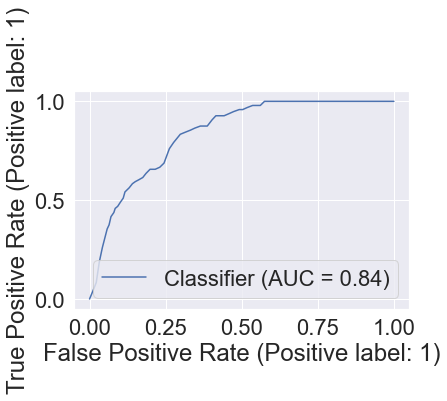

In [103]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

### Support Vector Classifier (SMOTE)

In [73]:
SMOTE_BEST_SVC = SVC(C=1000,gamma='scale',kernel='rbf')

In [74]:
SMOTE_BEST_SVC.fit(X_train_SMOTE,y_train_SMOTE)

SVC(C=1000)

In [75]:
print(confusion_matrix(y_test, SMOTE_BEST_SVC.predict(X_test_cleaned)))

[[1502   88]
 [  81   15]]


In [78]:
print(classification_report(y_test, SMOTE_BEST_SVC.predict(X_test_cleaned)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1590
           1       0.15      0.16      0.15        96

    accuracy                           0.90      1686
   macro avg       0.55      0.55      0.55      1686
weighted avg       0.90      0.90      0.90      1686



### Random Forest Classifier (SMOTE)

In [90]:
SMOTE_BEST_RF = RandomForestClassifier(max_depth=20, n_estimators=400)

In [91]:
SMOTE_BEST_RF.fit(X_train_SMOTE, y_train_SMOTE)

RandomForestClassifier(max_depth=20, n_estimators=400)

In [92]:
print(confusion_matrix(y_test,SMOTE_BEST_RF.predict(X_test_cleaned)))

[[1560   30]
 [  89    7]]


In [93]:
print(classification_report(y_test, SMOTE_BEST_RF.predict(X_test_cleaned)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1590
           1       0.19      0.07      0.11        96

    accuracy                           0.93      1686
   macro avg       0.57      0.53      0.53      1686
weighted avg       0.90      0.93      0.91      1686



In [94]:
print(confusion_matrix(y_train,SMOTE_BEST_RF.predict(X_train_cleaned)))

[[3267    3]
 [   0  153]]


### K-Nearest Neighbor Classifier (SMOTE)

In [84]:
SMOTE_BEST_KNN = KNeighborsClassifier(metric='euclidean', n_neighbors=15, weights='distance')

In [85]:
SMOTE_BEST_KNN.fit(X_train_SMOTE, y_train_SMOTE)

KNeighborsClassifier(metric='euclidean', n_neighbors=15, weights='distance')

In [86]:
print(confusion_matrix(y_test, SMOTE_BEST_KNN.predict(X_test_cleaned)))

[[1259  331]
 [  48   48]]


In [87]:
print(classification_report(y_test, SMOTE_BEST_KNN.predict(X_test_cleaned)))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1590
           1       0.13      0.50      0.20        96

    accuracy                           0.78      1686
   macro avg       0.54      0.65      0.54      1686
weighted avg       0.92      0.78      0.83      1686



## Conclusion

A combination of SMOTE and Logistic Regression yielded the best outcome. While said model makes a lot of Type I Errors (more than half of the test set was classified as target=1), it has the highest Recall at 96%. 

For this data, maximizing Recall is the most important thing--it's better to wrongly predict that someone had a stroke than to wrongly predict that someone didn't. 

Future tests should focus on advancing the Logistic Regression model seen in this notebook. Ideally, Recall will remain about the same and the False Positive Rate will decrease.